<a href="https://colab.research.google.com/github/nates27/multi-task-learning/blob/main/bt5151_gp_npk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports and Classes #

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import torch
import transformers
from transformers import AlbertTokenizer, AlbertModel, DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from torch import cuda
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = 'cuda' if cuda.is_available() else 'cpu'

### Neural Network ###

In [7]:
# class NetMultiTask(torch.nn.Module):
#     def __init__(self):
#         super(NetMultiTask, self).__init__()
#         self.net = AlbertModel.from_pretrained("albert-base-v2")
        
#         self.pre_classifier1 = torch.nn.Linear(768, 768)
#         self.dropout1 = torch.nn.Dropout(0.2)
#         self.classifier1 = torch.nn.Linear(768, 2)
        
#         self.pre_classifier2 = torch.nn.Linear(768, 768)
#         self.dropout2 = torch.nn.Dropout(0.2)
#         self.classifier2 = torch.nn.Linear(768, 3)

#     def forward(self, input_ids, attention_mask, token_type_ids, task_id):
#         output_1 = self.net(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         if task_id == 1:
#           pooler = self.pre_classifier1(pooler)
#           pooler = torch.nn.ReLU()(pooler)
#           pooler = self.dropout1(pooler)
#           output = self.classifier1(pooler)
#         elif task_id == 2:
#           pooler = self.pre_classifier2(pooler)
#           pooler = torch.nn.ReLU()(pooler)
#           pooler = self.dropout2(pooler)
#           output = self.classifier2(pooler)
#         else:
#             assert False, 'Bad Task ID passed'
#         return output

In [8]:
# class NetMultiTask(torch.nn.Module):
#     def __init__(self):
#         super(NetMultiTask, self).__init__()
#         self.net = AlbertModel.from_pretrained("albert-large-v2")
        
#         self.net.fc1 = torch.nn.Sequential(OrderedDict(
#             [('linear1', torch.nn.Linear(1024,1024)),
#             ('relu1', torch.nn.ReLU()),
#             ('dropout1', torch.nn.Dropout(0.2)),
#             ('final1', torch.nn.Linear(1024, 2))]))
        
#         self.net.fc2 = torch.nn.Sequential(OrderedDict(
#             [('linear2', torch.nn.Linear(1024, 1024)),
#             ('relu2', torch.nn.ReLU()),
#             ('dropout2', torch.nn.Dropout(0.2)),
#             ('final2', torch.nn.Linear(1024, 3))]))

#     def forward(self, input_ids, attention_mask, token_type_ids, task_id):
#         output_1 = self.net(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         if task_id == 1:
#             pooler =  self.net.fc1(pooler)
#         elif task_id == 2:
#             pooler = self.net.fc2(pooler)
#         else:
#             assert False, 'Bad Task ID passed'
#         return pooler

In [9]:
# class NetMultiTask(torch.nn.Module):
#     def __init__(self):
#         super(NetMultiTask, self).__init__()
#         self.net = RobertaModel.from_pretrained("roberta-base")
        
#         self.pre_classifier1 = torch.nn.Linear(768, 768)
#         self.dropout1 = torch.nn.Dropout(0.2)
#         self.classifier1 = torch.nn.Linear(768, 2)
        
#         self.pre_classifier2 = torch.nn.Linear(768, 768)
#         self.dropout2 = torch.nn.Dropout(0.2)
#         self.classifier2 = torch.nn.Linear(768, 3)

#     def forward(self, input_ids, attention_mask, token_type_ids, task_id):
#         output_1 = self.net(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         if task_id == 1:
#           pooler = self.pre_classifier1(pooler)
#           pooler = torch.nn.ReLU()(pooler)
#           pooler = self.dropout1(pooler)
#           output = self.classifier1(pooler)
#         elif task_id == 2:
#           pooler = self.pre_classifier2(pooler)
#           pooler = torch.nn.ReLU()(pooler)
#           pooler = self.dropout2(pooler)
#           output = self.classifier2(pooler)
#         else:
#             assert False, 'Bad Task ID passed'
#         return output

### Training and Inference Loops ###

#I. Data Preprocessing #

### EDA ###

In [10]:
def data_quality(df):
  # find datatype of each column
  data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])

  # count number of missing observations by column
  missing_data_counts = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])

  # count number of present observations by column
  present_data_counts = pd.DataFrame(df.count(), columns=['Present Values'])

  # count number of unique observations by column
  unique_value_counts = pd.DataFrame(columns=['Unique Values'])
  for v in list(df.columns.values):
      unique_value_counts.loc[v] = [df[v].nunique()]

  data_quality_report = pd.concat([present_data_counts, missing_data_counts, unique_value_counts], axis=1)
  return data_quality_report

In [11]:
d_train_orig = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/train.csv")
d_test_orig = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/test.csv")
s_train_orig = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/tweets.csv")

In [12]:
d_train_orig.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
d_test_orig.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
s_train_orig.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [15]:
print(f"d_train:{d_train_orig.shape}\nd_test:{d_test_orig.shape}\ns_test:{s_train_orig.shape}")

d_train:(7613, 5)
d_test:(3263, 4)
s_test:(27481, 4)


In [16]:
total = d_train_orig.target.value_counts().sum()
neg = d_train_orig.target.value_counts()[0]
pos = d_train_orig.target.value_counts()[1]
print(f"Not Disaster: Count = {neg} Percent = {neg/total}\n"
     f"Disaster:  Count = {pos} Percent = {pos/total}\n")

Not Disaster: Count = 4342 Percent = 0.5703402075397347
Disaster:  Count = 3271 Percent = 0.4296597924602653



In [17]:
total = s_train_orig.sentiment.value_counts().sum()
neu = s_train_orig.sentiment.value_counts()['neutral']
neg = s_train_orig.sentiment.value_counts()['negative']
pos = s_train_orig.sentiment.value_counts()['positive']
print(f"Neutral: Count = {neu} Percent = {neu/total}\n"
    f"Negative: Count = {neg} Percent = {neg/total}\n"
     f"Positve:  Count = {pos} Percent = {pos/total}\n")

Neutral: Count = 11118 Percent = 0.4045704304792402
Negative: Count = 7781 Percent = 0.2831410792911466
Positve:  Count = 8582 Percent = 0.3122884902296132



In [18]:
d_train_orig.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [19]:
s_train_orig.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [20]:
print(data_quality(d_train_orig))

          Present Values  Missing Values  Unique Values
id                  7613               0           7613
keyword             7552              61            221
location            5080            2533           3341
text                7613               0           7503
target              7613               0              2


In [21]:
print(data_quality(s_train_orig))

               Present Values  Missing Values  Unique Values
textID                  27481               0          27481
text                    27480               1          27480
selected_text           27480               1          22463
sentiment               27481               0              3


### Data Preprocessing ###

In [22]:
# Helper function that will sentiment to numerical values
def map_sentiment(x):
    if x == "negative":
        return 0
    elif x =="neutral":
        return 1
    elif x =="positive":
        return 2
    else:
        return None
# Custom Dataset for D1 that will tokenize text and arrange output and labels in a dictionary
class DisasterData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

# Custom Dataset for D2 that will tokenize text and arrange output and labels in a dictionary
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }
 

In [23]:
# Helper function to remove URLs. May or may not be used
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

In [24]:
# Creating copies of the dataset
d_train = d_train_orig.copy()
d_test = d_test_orig.copy()
s_train = s_train_orig.copy()

In [25]:
# Remove null values
s_train.drop(s_train[s_train["textID"]=="fdb77c3752"].index, inplace=True)

In [26]:
# Ignore removing URLs for now as tokenizer can probably handle URLs
# d_train['text'] = d_train.apply(lambda x: cleaning_URLs(x['text']),axis=1)
# #d_test['text'] = d_test.apply(lambda x: cleaning_URLs(x['text']),axis=1)
# s_train['text'] = s_train.apply(lambda x: cleaning_URLs(x['text']),axis=1)

In [27]:
# Removing duplicate text
d_train.drop_duplicates(subset=['text'], inplace=True)
d_train.shape

(7503, 5)

In [28]:
# Removing duplicate text
s_train.drop_duplicates(subset=['text'], inplace=True)
s_train.shape

(27480, 4)

In [29]:
# Adding task id to the datasets, might be need later on
d_train['id'] = 1
s_train['id'] = 2
d_train.reset_index(inplace=True)
s_train.reset_index(inplace=True)
s_train_text = s_train[['text','id','index']].copy()
d_train_text = d_train[['text','id','index']].copy()

In [30]:
# Mapping sentiment labels to numbers
s_train['sentiment'] = s_train.apply(lambda x: map_sentiment(x.sentiment), axis=1)
s_train.rename(columns={'sentiment':'target'}, inplace=True)
# Creating copies of the data for passing in to custom dataset
d_train_select =  d_train[['text','target']].copy()
s_train_select = s_train[['text','target']].copy()

In [31]:
# Creating the corpus of text as instructed, but won't be used
corpus = pd.concat([d_train_select[["text"]], s_train_select[['text']]])

In [32]:
corpus.shape

(34983, 1)

In [33]:
# Pre-trained tokenizer to be used
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# # Hyperparameters below for actual model used
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 32

# Hyperparameters below for experimenting on freezing the pre-trained MLM models
# MAX_LEN = 512
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32

In [34]:
# Create train-validate spilts
d_train_data, d_val_data = train_test_split(d_train_select, test_size=0.2, stratify=d_train_select['target'],
                                 random_state=2023)

s_train_data, s_val_data= train_test_split(s_train_select, test_size=0.2, stratify=s_train_select['target'],
                                 random_state=2023)

# Dropping the index because it can mess up the loops
d_train_data.reset_index(inplace=True,drop =True)
d_val_data.reset_index(inplace=True, drop =True)
s_train_data.reset_index(inplace=True, drop =True)
s_val_data.reset_index(inplace=True,  drop =True)

In [35]:
d_train_data.shape

(6002, 2)

In [36]:
s_train_data.head()

,text,target
0,Happy mother`s day nfty!!!!!!!!!!!!!!!!!!!!!!,2
1,"not you, me, just drank too much.",0
2,Brilliant Thanks! Not sure what brownie poin...,2
3,Does anyone update the photowalkingutah goog...,1
4,weee! internet is back here at home!,2


In [37]:
# Create D1 and D2 training and validation Datasets. This will tokenize the datasets on the fly
d1_train_set= DisasterData(d_train_data, tokenizer, MAX_LEN)
d1_val_set = DisasterData(d_val_data, tokenizer, MAX_LEN)

d2_train_set= SentimentData(s_train_data, tokenizer, MAX_LEN)
d2_val_set = SentimentData(s_val_data, tokenizer, MAX_LEN)

In [38]:
# Create D1 and D2 dataloaders
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

d1_train_loader = DataLoader(d1_train_set, **train_params)
d1_val_loader = DataLoader(d1_val_set, **test_params)

d2_train_loader = DataLoader(d2_train_set, **train_params)
d2_val_loader = DataLoader(d2_val_set, **test_params)

# II. Model Training #

In [39]:
# Final architecture to be used for Task 1 and Task 2
class NetMultiTask(torch.nn.Module):
    def __init__(self):
        super(NetMultiTask, self).__init__()
        self.net = RobertaModel.from_pretrained("roberta-base")
        
        self.pre_classifier1 = torch.nn.Linear(768, 768)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.classifier1 = torch.nn.Linear(768, 2)
        
        self.pre_classifier2 = torch.nn.Linear(768, 768)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.classifier2 = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.net(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
      
        pooler1 = self.pre_classifier1(pooler)
        pooler1 = torch.nn.ReLU()(pooler1)
        pooler1 = self.dropout1(pooler1)
        output1 = self.classifier1(pooler1)

        pooler2 = self.pre_classifier2(pooler)
        pooler2 = torch.nn.ReLU()(pooler2)
        pooler2 = self.dropout2(pooler2)
        output2 = self.classifier2(pooler2)
        
        return output1, output2

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L., & Stoyanov, V. (2019). RoBERTa: A robustly optimized BERT pretraining approach. CoRR, abs/1907.11692.

**Question**: Assume the model is deployed in a server within your news agency. Explain the inputs to the model and predictions that it is expected to output. Also explain how the predictions will be used by reporters.

**Answer**:<br>
<p>We are using the RoBERTa architecture in thie model above where we use its embeddings on two classifiers in the same neural network. The raw inputs to the model can be any text, but in this project's context it will be tweets on which the model will be trained on. The text must first be passed to RoBERTa's pre-trained tokenizer which will convert the text to the tensors and attention masks needed for the RoBERTa model. The tensors and attentioin masks will then pass through RoBERTa's architecture and we will use its last hidden state as word embeddings. The word embeddings will then be passed to two separate dense layers with different heads. The first will head has two outputs and the second head as three outputs.</p>
<p>The first head can be used by reporters to classify a tweet if it's pertaining to a disaster or not. These can be used by reporters for example as an early warning system where the system can get tweets through the Twitter API, pass it through the model, predict the tweets, and then notifiy reporters if there are large amounts of disaster tweets happening in real time. This will enable them to respond and report on disasters quickly.</p>
<p>The second head can be used by reporters and the news agency to gauge sentiment on their news/opinion articles released on twitter and then track its engagement. This can be done by setting up a sentiment analysis system using this model. The system can work by pulling replies or retweets from the reporters' tweets using the Twitter API, passing them through the model to get sentiment predictions, and then analyzing sentiment classes of the reporters' tweets.

# III. Neural Network Multi Task Learing #

### Task 3.1 and Task 3.2 ###
1. Train the model M only for T1 on Dtrain. Call the trained val 1
model MD . Evaluate MD on D and report its 111
performance metric (F1 score) for the first task, PerfT (MD |Dval). Also print the confusion matrix. ###

2. Train the model M only for T2 on Dtrain . Call the trained
model M . Evaluate the trained M2 on Dval and report D2 D2 2 val
its performance metric (Accuracy) PerfT (MD |D Also print the confusion matrix.

#### Helper functions for the training and validation loops ####

In [40]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [41]:
def train(model, epoch, training_loader, mode):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()

    
    for _,data in enumerate(tqdm(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        output1, output2 = model(ids, mask, token_type_ids)

        if mode == 1:
            output = output1
        elif mode == 2:
            output = output2
        else:
            assert False, 'Bad Task ID passed'


        loss = loss_function(output, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(output.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    return

def valid(model, testing_loader, mode):
    model.eval()
    #n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    tr_loss=0
    predicts = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            output1, output2 = model(ids, mask, token_type_ids)

            if mode == 1:
                output = output1
            elif mode == 2:
                output = output2
            else:
                assert False, 'Bad Task ID passed'

            loss = loss_function(output, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(output.data, dim=1)
            
            for i in range(targets.size(0)):
                predicts.append({
                    "predict": big_idx[i].item(),
                    "target": targets[i].item()
                })
    df = pd.DataFrame(predicts)
    return df

#### Training code used ####

In [42]:
# Specifying the learning rate for both tasks
LEARNING_RATE = 1e-05

In [43]:
## Train on first task. Commented out since training done outside of this notebook
# net1 = NetMultiTask()
# net1.to(device)
# #for training only the classification layer

# # for param in net1.net.parameters():
# #     param.requires_grad = False

# EPOCHS = 3
# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = net1.parameters(), lr = LEARNING_RATE)
# for epoch in range(EPOCHS):
#     train(net1, epoch, d1_train_loader, mode = 1)

# Getting validation predictions
# predicts_d1  = valid(net1, d1_val_loader, mode = 1)


In [44]:
## Train on first task. Commented out since training done outside of this notebook
# net2 = NetMultiTask()
# net2.to(device)

# # for param in net2.net.parameters():
# #     param.requires_grad = False

# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = net2.parameters(), lr = LEARNING_RATE)
# EPOCHS = 5
# for epoch in range(EPOCHS):
#     train(net2, epoch, d2_train_loader, mode = 2)

# Getting validation predictions
# predicts_d2  = valid(net2, d2_val_loader, mode = 2)

In [45]:
# Code to save model so we can replicate the predictions
# net1_bin = "./net1.bin"
# net2_bin = "./net2.bin"

# Saving models and validation predictions to local
# predicts_d1.to_csv("./predicts_d1.csv")
# predicts_d2.to_csv("./predicts_d2.csv")
# torch.save(net1, net1_bin)
# torch.save(net2, net2_bin)

#### Perfomance Metrics and Confusion Matrices ####

In [46]:
# Loading the saved predictions for reporting metrics
predicts_d1 = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/predicts_d1_roberta_final.csv", index_col=0)
predicts_d2 = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/predicts_d2_roberta_final.csv", index_col=0)

In [47]:
print(classification_report(predicts_d1.target, predicts_d1.predict))
print(f"D1 F1: {f1_score(predicts_d1.target, predicts_d1.predict)}\n"
      f"D1 Accuracy: {accuracy_score(predicts_d1.target, predicts_d1.predict)}\n")

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       861
           1       0.82      0.77      0.80       640

    accuracy                           0.83      1501
   macro avg       0.83      0.82      0.83      1501
weighted avg       0.83      0.83      0.83      1501

D1 F1: 0.7974172719935432
D1 Accuracy: 0.832778147901399



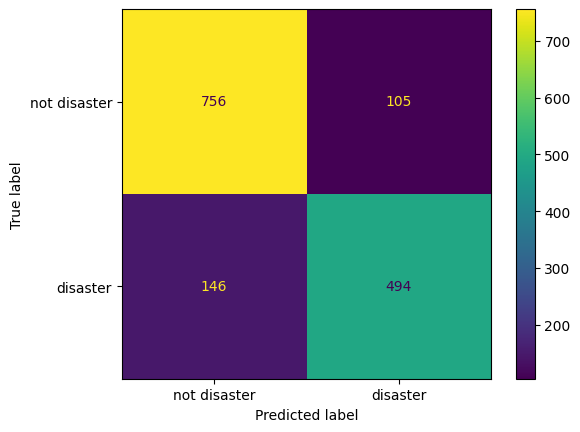

In [48]:
cm_d1 = confusion_matrix(predicts_d1.target, predicts_d1.predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d1, display_labels=['not disaster', 'disaster'])
disp.plot()
plt.show()

In [49]:
print(classification_report(predicts_d2.target, predicts_d2.predict))
print(f"D2 F1: {f1_score(predicts_d2.target, predicts_d2.predict, average='weighted')}\n"
      f"D2 Accuracy: {accuracy_score(predicts_d2.target, predicts_d2.predict)}\n")

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1556
           1       0.76      0.75      0.76      2223
           2       0.80      0.88      0.84      1717

    accuracy                           0.79      5496
   macro avg       0.80      0.79      0.79      5496
weighted avg       0.79      0.79      0.79      5496

D2 F1: 0.7896766952626569
D2 Accuracy: 0.7905749636098981



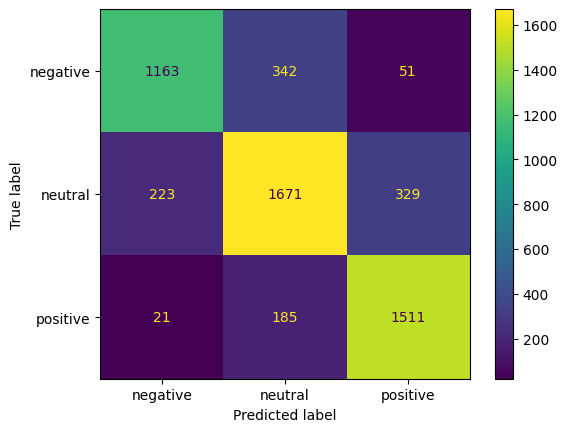

In [50]:
cm_d2 = confusion_matrix(predicts_d2.target, predicts_d2.predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d2, display_labels=['negative', 'neutral','positive'])
disp.plot()
plt.show()

### Task 3.3 ###
Estimate the sentiment labels for the tweets in D1

In [51]:
model_path = "/content/drive/MyDrive/BT5151/group_project/roberta_d2_final.bin" 
model_d2 = torch.load(model_path, map_location=device)

In [52]:
data_quality(d_train_orig)

,Present Values,Missing Values,Unique Values
id,7613,0,7613
keyword,7552,61,221
location,5080,2533,3341
text,7613,0,7503
target,7613,0,2


In [53]:
d1_train_infer = SentimentData(d_train_orig, tokenizer, MAX_LEN)

In [54]:
test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
d1_infer_loader = DataLoader(d1_train_infer, **test_params)

In [55]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_d2.parameters(), lr = LEARNING_RATE)
predicts_d1_infer = valid(model_d2, d1_infer_loader, mode=2)

100%|██████████| 238/238 [04:03<00:00,  1.02s/it]


In [56]:
predicts_d1_infer['predict'].value_counts()

1    4146
0    2430
2    1037
Name: predict, dtype: int64

In [57]:
predicts_d1_infer.head()

,predict,target
0,0,1
1,1,1
2,1,1
3,1,1
4,1,1


In [58]:
predicts_d1_infer.drop(columns='target', inplace=True)

In [59]:
d1_augment = d_train_orig.merge(predicts_d1_infer, left_index=True, right_index=True)
d1_augment.rename({'predict': 'sentiment'}, axis =1, inplace=True)

In [60]:
d1_augment.head()

,id,keyword,location,text,target,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1


In [61]:
d1_augment['sentiment'].value_counts()

1    4146
0    2430
2    1037
Name: sentiment, dtype: int64

In [62]:
d1_augment.shape

(7613, 6)

In [63]:
d_train_orig.shape

(7613, 5)

In [64]:
data_quality(d1_augment)

,Present Values,Missing Values,Unique Values
id,7613,0,7613
keyword,7552,61,221
location,5080,2533,3341
text,7613,0,7503
target,7613,0,2
sentiment,7613,0,3


In [65]:
# Saving d1_augment for future use
#d1_augment.to_csv("/content/drive/MyDrive/BT5151/group_project/d1_augment.csv")

Analysis: 

#V. Further Exploration #

### Strategy 1 ####

Retrain and fine-tune the SiEBERT English-Language model for disaster classification
<br>
<br>
Explanation:
<p>The SiEBERT model is a sentiment classification model which was trained on 15 text corpus to make it as robust as possible for classifying sentiment. It is also a derivative of the RoBERTa architecture which we used for the initial parts of this project. This model also has two outputs which is compatible with our task of a binary classification for disaster tweets. The strategy is to retrain and fine-tune this SiEBERT model to instead classify tweets that announces disasters using this project's dataset. Based on its performance report on different NLP benchmarks, this model has very good generalized performance so SieBERT's model architecture might yield higher accuracy also for disaster classification.</p>
<br>
Citation:<br>
Hartmann, J., Heitmann, M., Siebert, C., & Schamp, C. (2023). More than a Feeling: Accuracy and Application of Sentiment Analysis. International Journal of Research in Marketing, 40(1), 75-87. https://doi.org/10.1016/j.ijresmar.2022.05.005

In [66]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import evaluate

In [67]:
# Using RoBERTa tokenizer since siebert is based on RoBERTa-large
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

In [68]:
# Creating train-test splits for training the model
d_train_data, d_val_data, d_train_labels, d_val_labels = train_test_split(d_train_select['text'],d_train_select['target'], test_size=0.2, 
                                                                       stratify=d_train_select['target'], random_state=2023)

In [69]:
# Resetting indices as it might break some loopes
d_train_data.reset_index(inplace=True, drop=True)
d_val_data.reset_index(inplace=True, drop=True)
d_train_labels.reset_index(inplace=True, drop=True)
d_val_labels.reset_index(inplace=True, drop=True)

In [70]:
# Tokenizing the data
train_encodings = tokenizer(d_train_data.tolist(), truncation=True, padding="max_length", add_special_tokens=True, 
                            return_token_type_ids=True)
val_encodings = tokenizer(d_val_data.tolist(), truncation=True, padding="max_length", add_special_tokens=True, 
                            return_token_type_ids=True)

In [71]:
# Creating custom Datasets classes for the data
class HuggingData(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [72]:
# Creating the datasets
dstrat1_train_set = HuggingData(train_encodings, d_train_labels)
dstrat1_val_set = HuggingData(val_encodings, d_val_labels)

In [73]:
# Loading the siebert sentiment classification model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")
# Specifying the training arguments for training using HuggingFace Trainer API
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/BT5151/group_project/strategy1/output",
    optim="adamw_torch",
    num_train_epochs=3,
    learning_rate= 1e-5,
    lr_scheduler_type = "cosine",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy="no",
    warmup_steps= 10,
    weight_decay = 0.01,
    logging_dir="/content/drive/MyDrive/BT5151/group_project/strategy1/logs",
    logging_strategy="steps",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100
)

In [74]:
# Specifying evaluation metrics
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [75]:
# Calling the trainer API and initiates training. Training was done outside of this notebook
# trainer = Trainer(
#     model=model,                         
#     args=training_args,                
#     train_dataset=dstrat1_train_set,
#     eval_dataset=dstrat1_val_set,
#     compute_metrics=compute_metrics
# )

# trainer.train()

# Saving the model
#trainer.save_model("/content/drive/MyDrive/BT5151/group_project/strategy1/models")

Inference on the trained on the siebert model

In [76]:
from transformers import pipeline, AutoModel

In [77]:
# Creating a pipeline for inference on the fine-tuned siebert model
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
disaster = pipeline("text-classification", model="/content/drive/MyDrive/BT5151/group_project/siebert_final_strat1", tokenizer = tokenizer, device="cuda:0",
                    binary_output=True, function_to_apply="softmax")

In [78]:
# Creating an iterator for the D1 test data
def data_iterator(df):
    for i in range(df.shape[0]):
        yield str(df.text[i])

In [79]:
# Helper function to extract the outputs of the pipeline in a nice dataframe
def get_predict(iterator, pipeline):
    df = pd.DataFrame(columns = ['label', 'score'])
    for idx, out in enumerate(tqdm(pipeline(iterator))):
        df.loc[idx] = out
    return df

In [80]:
# Helper function to reformat pipeline outputs dataframe for Kaggle test submission format
def clean_submit(preds):
    df = preds.copy()
    df.reset_index(inplace=True)
    df.rename(columns = {'index':'id'}, inplace = True)
    df.set_index("id", inplace=True)
    df['target'] = df.apply(lambda x: 1 if x['label'] == 'POSITIVE' else 0, axis = 1)
    df.drop(columns=['score', 'label'], inplace=True)
    return df

In [81]:
# Getting predictions for the train for checking
#preds_train = get_predict(data_iterator(d_train), disaster)

# Getting predictions for the test data
preds_test = get_predict(data_iterator(d_test_orig), disaster)

# Reformatting predictions for Kaggle submission format
#submit_train = clean_submit(preds_train)
submit_test = clean_submit(preds_test)

# Matching the predictions indices to the Kaggle sample submission indices
submit_test.reset_index(inplace=True)
test = d_test_orig[["id"]].copy()
merged = test.merge(submit_test, left_index=True, right_index=True, suffixes=(None, "_s"))
merged.drop(labels=["id_s"],axis=1,inplace=True)
merged.set_index("id",inplace=True)

#submit_train.to_csv("submit_train.csv")
# Save predictions for submission to Kaggle
#merged.to_csv("submit_test.csv")

3263it [01:38, 33.01it/s]


In [82]:
merged.shape

(3263, 1)

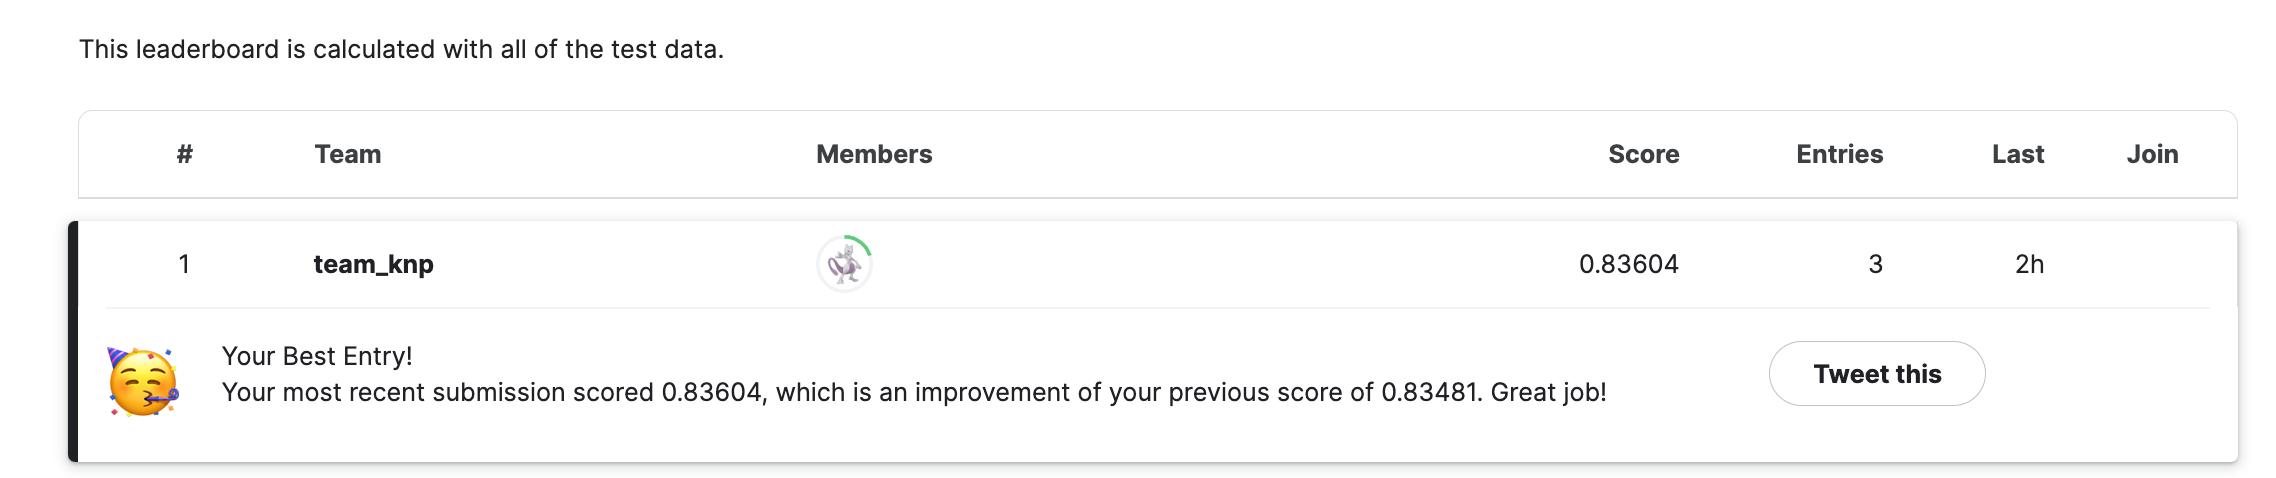